In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi
import source.quadrature as quad

%load_ext autoreload
%autoreload 2

In [2]:
def icosahedron():
    t = (1.0 + np.sqrt(5.0)) / 2.0
    V = np.array([
        [-1,  t, 0],
        [ 1,  t, 0],
        [-1, -t, 0],
        [ 1, -t, 0],
        [ 0, -1,  t],
        [ 0,  1,  t],
        [ 0, -1, -t],
        [ 0,  1, -t],
        [ t,  0, -1],
        [ t,  0,  1],
        [-t,  0, -1],
        [-t,  0,  1],
    ], dtype=float)
    V /= np.linalg.norm(V, axis=1)[:, None]
    F = np.array([
        [0, 11, 5], [0, 5, 1], [0, 1, 7], [0, 7,10], [0,10,11],
        [1, 5, 9], [5,11, 4], [11,10,2], [10,7,6], [7, 1, 8],
        [3, 9, 4], [3, 4, 2], [3, 2, 6], [3, 6, 8], [3, 8, 9],
        [4, 9, 5], [2, 4,11], [6, 2,10], [8, 6, 7], [9, 8, 1]
    ], dtype=int)
    return V, F

def subdivide_sphere(V, F, levels=1):
    """Loop-subdivide each triangle and re-project to unit sphere."""
    for _ in range(levels):
        mid_cache = {}
        newF = []
        def midpoint(i, j):
            key = tuple(sorted((i, j)))
            if key in mid_cache: return mid_cache[key]
            m = (V[i] + V[j]) * 0.5
            m = m / np.linalg.norm(m)
            idx = len(V_list)
            V_list.append(m)
            mid_cache[key] = idx
            return idx
        V_list = [v.copy() for v in V]
        for a,b,c in F:
            ab = midpoint(a,b)
            bc = midpoint(b,c)
            ca = midpoint(c,a)
            newF += [
                [a, ab, ca],
                [b, bc, ab],
                [c, ca, bc],
                [ab, bc, ca],
            ]
        V = np.asarray(V_list)
        F = np.asarray(newF, dtype=int)
    return V, F


a = 0.075              # sphere radius [m]
subdiv = 3
V, F = icosahedron()
V, F = subdivide_sphere(V, F, levels=subdiv)
V = a * V              # scale to radius a

area_exact = 4.0 * pi * a * a

# integrate constant f(y)=1 over the surface using triangle quadrature
pts, w = quad.standard_triangle_quad(order=1)

area_quad = 0.0
for (i,j,k) in F:
    tri = V[[i,j,k], :]
    v0 = tri[0]
    e1 = tri[1] - v0
    e2 = tri[2] - v0
    yq, a2 = quad.map_to_physical_triangle(pts, v0, e1, e2)
    area_quad += np.sum(w) * a2

def triangle_area(t):
    e1 = t[1] - t[0]
    e2 = t[2] - t[0]
    return 0.5 * np.linalg.norm(np.cross(e1, e2))
area_mesh = np.sum([triangle_area(V[[i,j,k]]) for (i,j,k) in F])

print(f"Triangles: {len(F)}, Nodes: {len(V)}")
print(f"Analytic area       = {area_exact:.8f} m^2")
print(f"Quadrature area     = {area_quad:.8f} m^2")
print(f"Mesh (geom) area    = {area_mesh:.8f} m^2")


Triangles: 1280, Nodes: 642
Analytic area       = 0.07068583 m^2
Quadrature area     = 0.07034902 m^2
Mesh (geom) area    = 0.07034902 m^2


In [3]:
def integrate_nodal_field_over_surface(V, F, nodal_values, quad_order=7):
    pts, w = quad.standard_triangle_quad(order=quad_order)
    Nvals = quad.shape_functions_P1(pts)
    total = 0.0

    for (i,j,k) in F:
        tri_xyz = V[[i,j,k], :]
        v0 = tri_xyz[0]
        e1 = tri_xyz[1] - v0
        e2 = tri_xyz[2] - v0
        yq, a2 = quad.map_to_physical_triangle(pts, v0, e1, e2)
        f_loc = np.array([nodal_values[i], 
                          nodal_values[j], 
                          nodal_values[k]], dtype=float)

        f_q = Nvals @ f_loc

        total += np.sum(w * f_q) * a2

    return total

# --- Case A: constant field f ≡ 1 via nodal interpolation ---
f_nodes_const = np.ones(V.shape[0], dtype=float)
I_const = integrate_nodal_field_over_surface(V, F, f_nodes_const, quad_order=7)

print(f"Interpolated constant field integral  = {I_const:.8f} m^2")
print(f"Analytic sphere area                  = {area_exact:.8f} m^2")

Interpolated constant field integral  = 0.07034902 m^2
Analytic sphere area                  = 0.07068583 m^2


In [4]:
# --- Case B: linear field f(y)=z via nodal interpolation ---
u_hat = np.array([0.0, 0.0, 1.0])                 # z-direction
f_nodes_lin = V @ u_hat                            # f(y)=z at nodes
I_lin = integrate_nodal_field_over_surface(V, F, f_nodes_lin, quad_order=7)
print("Integral of z over sphere (should be ~0):", I_lin)

Integral of z over sphere (should be ~0): -9.621728548262067e-20


In [5]:
# --- Case C: quadratic field f(y)=z^2 via nodal interpolation ---
f_nodes_quad = (V[:,2]**2)
I_z2 = integrate_nodal_field_over_surface(V, F, f_nodes_quad, quad_order=7)
print("Integral of z^2 over sphere (expect ~ (4πa^4)/3 ):",
      I_z2, " vs ", (4.0*pi*a**4)/3.0)

Integral of z^2 over sphere (expect ~ (4πa^4)/3 ): 0.00013190441550084295  vs  0.00013253594007331938


In [6]:
# 1) standard rules sum to 0.5
for o in (1,3,7):
    _, w = quad.standard_triangle_quad(o)
    print(f"Std rule {o}: sum(w)={w.sum():.2f}")

# 2) duffy sum is 0.5
_, w = quad.duffy_rule(8)
print(f"Duffy: sum(w)={w.sum():.2f}")

# 3) telles sum is 0.5
_, w = quad.telles_rule(u_star=0.2, v_star=0.3, n_leg=8)
print(f"Telles: sum(w)={w.sum():.2f}")

Std rule 1: sum(w)=0.50
Std rule 3: sum(w)=0.50
Std rule 7: sum(w)=0.50
Duffy: sum(w)=0.50
Telles: sum(w)=0.50


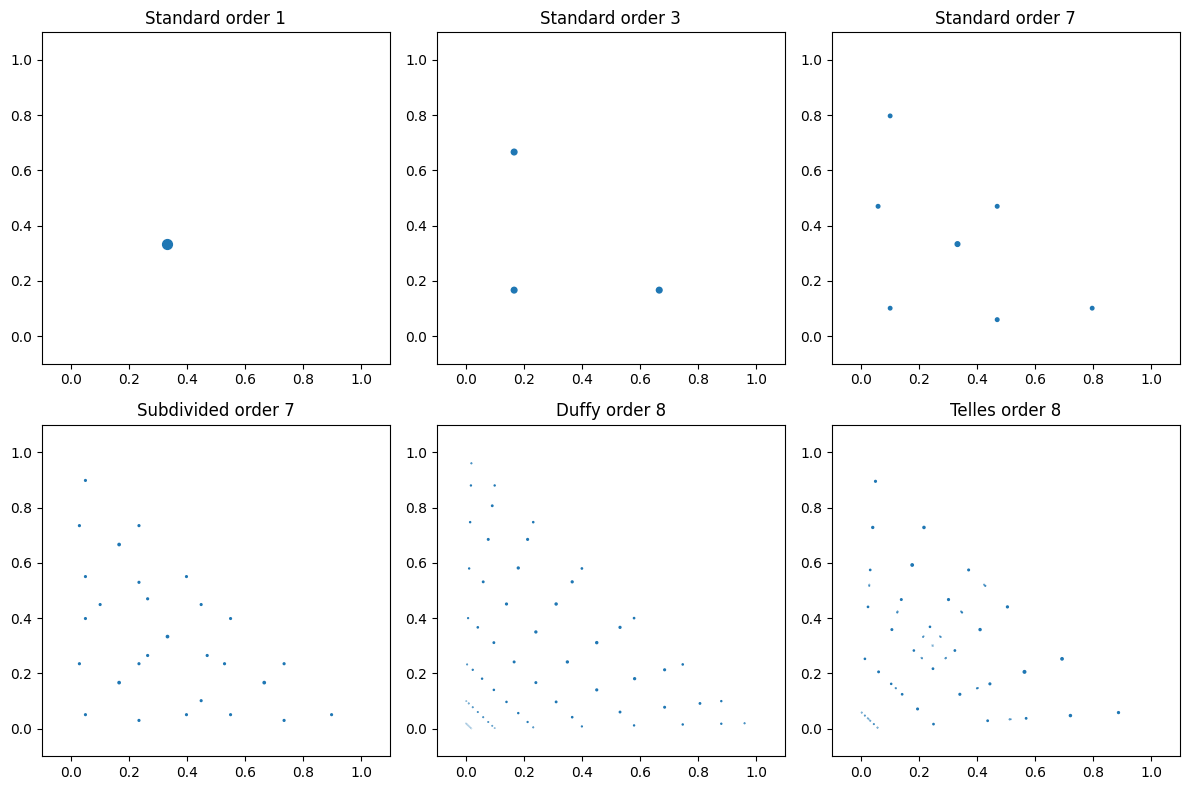

In [47]:
pts_1, w_1 = quad.standard_triangle_quad(order=1)
pts_3, w_3 = quad.standard_triangle_quad(order=3)
pts_7, w_7 = quad.standard_triangle_quad(order=7)
pts_sub, w_sub = quad.subdivide_triangle_quad(xi_eta=pts_7, weights=w_7, levels=1)
pts_duffy, w_duffy = quad.duffy_rule(8)
pts_telles, w_telles = quad.telles_rule(u_star=0.55, v_star=0.55, n_leg=8)

plt.subplots(2,3, figsize=(12,8))

plt.subplot(2, 3, 1)
plt.scatter(pts_1[:,0], pts_1[:,1], s=100*w_1, c='C0')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.title("Standard order 1")

plt.subplot(2, 3, 2)
plt.scatter(pts_3[:,0], pts_3[:,1], s=100*w_3, c='C0')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.title("Standard order 3")

plt.subplot(2, 3, 3)
plt.scatter(pts_7[:,0], pts_7[:,1], s=100*w_7, c='C0')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.title("Standard order 7")

plt.subplot(2, 3, 4)
plt.scatter(pts_sub[:,0], pts_sub[:,1], s=100*w_sub, c='C0')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.title("Subdivided order 7")

plt.subplot(2, 3, 5)
plt.scatter(pts_duffy[:,0], pts_duffy[:,1], s=100*w_duffy, c='C0')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.title("Duffy order 8")

plt.subplot(2, 3, 6)
plt.scatter(pts_telles[:,0], pts_telles[:,1], s=100*w_telles, c='C0')
plt.xlim(-0.1,1.1)
plt.ylim(-0.1,1.1)
plt.title("Telles order 8")
plt.tight_layout()
plt.show()